C:\Users\nadda\AppData\Local\Temp\ipykernel_24008\41121268.py:106: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  crime_holiday["is_holiday"] = crime_holiday["is_holiday"].fillna(False)


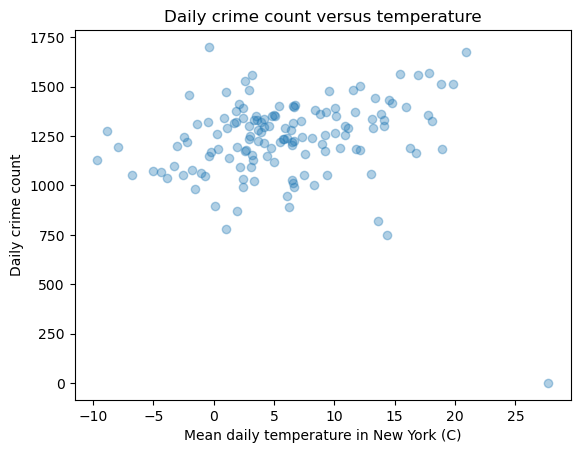

C:\Users\nadda\AppData\Local\Temp\ipykernel_24008\41121268.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = crime_weather.groupby("temp_bin")["crime_count"].mean().reset_index()


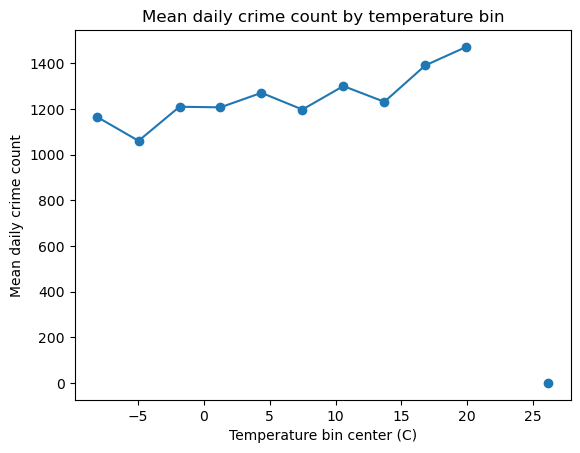

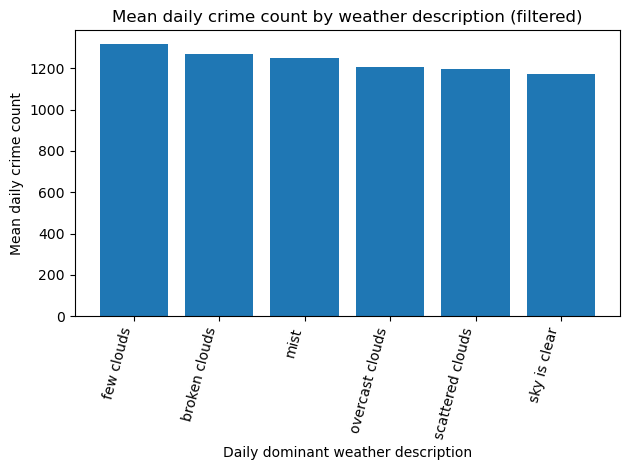

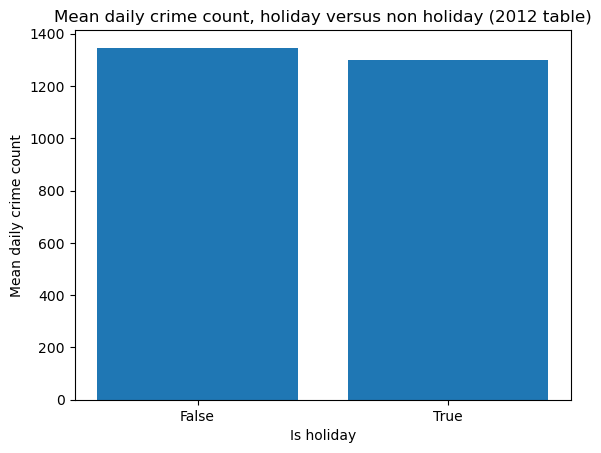

C:\Users\nadda\AppData\Local\Temp\ipykernel_24008\41121268.py:174: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([nonholiday_counts, holiday_counts], labels=["Non holiday", "Holiday"])


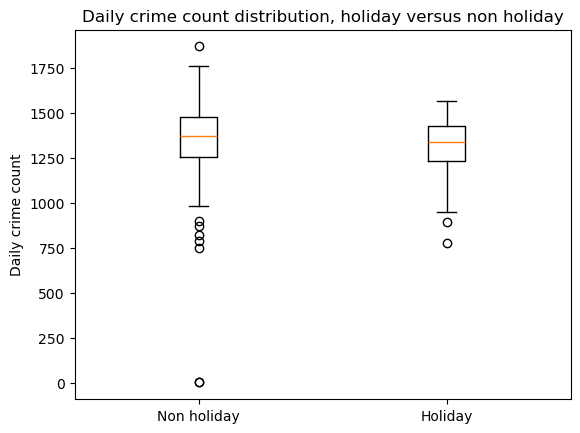

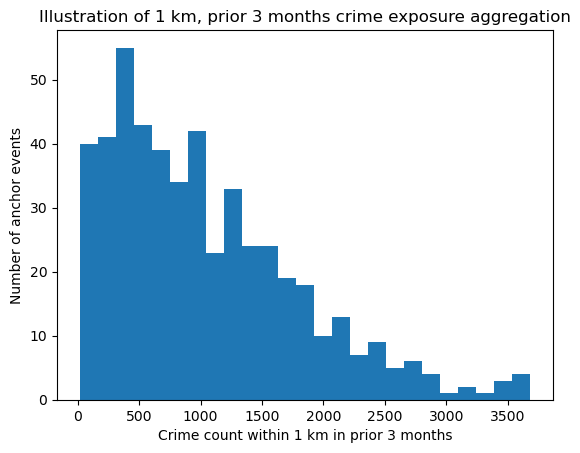

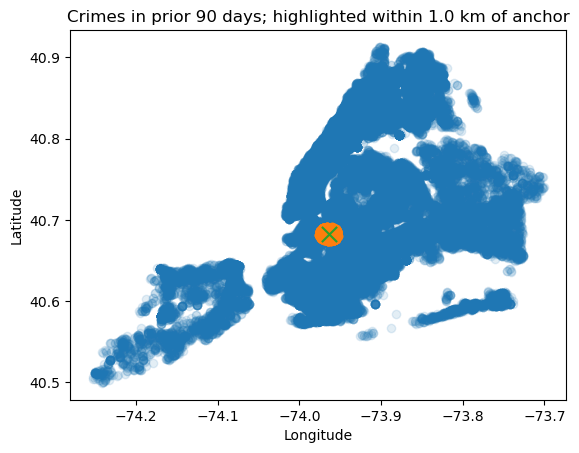

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt

# =========================
# Paths, update if needed
# =========================
CRIMES_PATH = "../data/NYPD_CrimeData/Preprocessed_forsquare_nyc_alligned_subset_data.csv"
TEMPERATURE_PATH = "../data/NYC_checkins/extra_data_to_combine/temperature.csv"
WEATHER_DESC_PATH = "../data/NYC_checkins/extra_data_to_combine/weather_description.csv"
HOLIDAYS_PATH = "../data/NYC_checkins/extra_data_to_combine/holidays_2012.csv"

# If you run this in the same folder as the CSVs, the relative paths above are fine.
# Otherwise, replace them with full paths.

# =========================
# Helpers
# =========================

def haversine_km(lat1, lon1, lat2, lon2) -> float:
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * R * asin(sqrt(a))

def ensure_datetime_utc(series: pd.Series) -> pd.Series:
    return pd.to_datetime(series, errors="coerce", utc=True)

def kelvin_to_c(k: float) -> float:
    return k - 273.15

# =========================
# Load data
# =========================

crimes = pd.read_csv(CRIMES_PATH)
temperature = pd.read_csv(TEMPERATURE_PATH)
weather_desc = pd.read_csv(WEATHER_DESC_PATH)
holidays = pd.read_csv(HOLIDAYS_PATH)

# =========================
# Prepare crime data
# =========================

# Your crime dataset has complaint_date_start already as a combined timestamp string
crimes["datetime"] = ensure_datetime_utc(crimes["complaint_date_start"])
crimes["date"] = crimes["datetime"].dt.date
crimes["date"] = pd.to_datetime(crimes["date"])

crimes["lat"] = pd.to_numeric(crimes["Latitude"], errors="coerce")
crimes["lng"] = pd.to_numeric(crimes["Longitude"], errors="coerce")
crimes = crimes.dropna(subset=["datetime", "date", "lat", "lng"]).reset_index(drop=True)

daily_crime = crimes.groupby("date").size().reset_index(name="crime_count")

# =========================
# Prepare weather data for New York
# =========================

temperature["datetime"] = pd.to_datetime(temperature["datetime"], errors="coerce", utc=True)
weather_desc["datetime"] = pd.to_datetime(weather_desc["datetime"], errors="coerce", utc=True)

# Extract New York only
temp_ny = temperature[["datetime", "New York"]].copy()
desc_ny = weather_desc[["datetime", "New York"]].copy()

temp_ny = temp_ny.rename(columns={"New York": "temp_k"})
desc_ny = desc_ny.rename(columns={"New York": "weather_text"})

temp_ny["temp_c"] = pd.to_numeric(temp_ny["temp_k"], errors="coerce").apply(
    lambda x: kelvin_to_c(x) if pd.notna(x) else np.nan
)

temp_ny["date"] = temp_ny["datetime"].dt.date
temp_ny["date"] = pd.to_datetime(temp_ny["date"])

desc_ny["date"] = desc_ny["datetime"].dt.date
desc_ny["date"] = pd.to_datetime(desc_ny["date"])

# Daily aggregation
daily_temp = temp_ny.groupby("date")["temp_c"].mean().reset_index()
daily_weather_mode = (
    desc_ny.dropna(subset=["weather_text"])
    .groupby("date")["weather_text"]
    .agg(lambda s: s.value_counts().index[0] if len(s) else np.nan)
    .reset_index()
)

daily_weather = daily_temp.merge(daily_weather_mode, on="date", how="left")

# Merge crimes with weather
crime_weather = daily_crime.merge(daily_weather, on="date", how="inner").dropna(subset=["temp_c"])

# =========================
# Prepare holidays
# =========================

holidays["date"] = pd.to_datetime(holidays["Date"], errors="coerce")
holidays = holidays.dropna(subset=["date"]).copy()
holidays["is_holiday"] = True

crime_holiday = daily_crime.merge(holidays[["date", "is_holiday", "Holiday_Name"]], on="date", how="left")
crime_holiday["is_holiday"] = crime_holiday["is_holiday"].fillna(False)

# =========================
# 1) Graphs, Weather and Temperature versus crime
# =========================

plt.figure()
plt.scatter(crime_weather["temp_c"], crime_weather["crime_count"], alpha=0.35)
plt.xlabel("Mean daily temperature in New York (C)")
plt.ylabel("Daily crime count")
plt.title("Daily crime count versus temperature")
plt.show()

# Optional, smoother view by binning temperature
crime_weather = crime_weather.copy()
crime_weather["temp_bin"] = pd.cut(crime_weather["temp_c"], bins=12)
binned = crime_weather.groupby("temp_bin")["crime_count"].mean().reset_index()
binned["bin_center"] = binned["temp_bin"].apply(lambda x: (x.left + x.right) / 2)

plt.figure()
plt.plot(binned["bin_center"], binned["crime_count"], marker="o")
plt.xlabel("Temperature bin center (C)")
plt.ylabel("Mean daily crime count")
plt.title("Mean daily crime count by temperature bin")
plt.show()

# Weather description categories, mean crime per category
weather_cat = crime_weather.dropna(subset=["weather_text"]).copy()
weather_summary = (
    weather_cat.groupby("weather_text")["crime_count"]
    .agg(["mean", "count"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

# Keep only categories with enough days to be meaningful
weather_summary = weather_summary[weather_summary["count"] >= 10].copy()

plt.figure()
plt.bar(weather_summary["weather_text"], weather_summary["mean"])
plt.xticks(rotation=75, ha="right")
plt.xlabel("Daily dominant weather description")
plt.ylabel("Mean daily crime count")
plt.title("Mean daily crime count by weather description (filtered)")
plt.tight_layout()
plt.show()

# =========================
# 2) Graphs, Holidays versus non holidays
# =========================

holiday_stats = (
    crime_holiday.groupby("is_holiday")["crime_count"]
    .agg(["mean", "median", "count"])
    .reset_index()
)

plt.figure()
plt.bar(holiday_stats["is_holiday"].astype(str), holiday_stats["mean"])
plt.xlabel("Is holiday")
plt.ylabel("Mean daily crime count")
plt.title("Mean daily crime count, holiday versus non holiday (2012 table)")
plt.show()

holiday_counts = crime_holiday.loc[crime_holiday["is_holiday"] == True, "crime_count"].values
nonholiday_counts = crime_holiday.loc[crime_holiday["is_holiday"] == False, "crime_count"].values

plt.figure()
plt.boxplot([nonholiday_counts, holiday_counts], labels=["Non holiday", "Holiday"])
plt.ylabel("Daily crime count")
plt.title("Daily crime count distribution, holiday versus non holiday")
plt.show()

# =========================
# 3) Illustrate the 1 km radius, prior 3 months aggregation
# =========================

def compute_exposure_for_anchors(
    anchors_df: pd.DataFrame,
    crimes_df: pd.DataFrame,
    radius_km: float = 1.0,
    window_days: int = 90,
    anchor_time_col: str = "datetime",
    anchor_lat_col: str = "lat",
    anchor_lng_col: str = "lng",
) -> pd.DataFrame:
    anchors = anchors_df.copy()
    crm = crimes_df.copy()

    anchors[anchor_time_col] = ensure_datetime_utc(anchors[anchor_time_col])
    crm["datetime"] = ensure_datetime_utc(crm["datetime"])

    anchors[anchor_lat_col] = pd.to_numeric(anchors[anchor_lat_col], errors="coerce")
    anchors[anchor_lng_col] = pd.to_numeric(anchors[anchor_lng_col], errors="coerce")

    anchors = anchors.dropna(subset=[anchor_time_col, anchor_lat_col, anchor_lng_col]).reset_index(drop=True)
    crm = crm.dropna(subset=["datetime", "lat", "lng"]).reset_index(drop=True)

    counts = []
    for _, a in anchors.iterrows():
        t = a[anchor_time_col]
        t0 = t - pd.Timedelta(days=window_days)

        subset = crm[(crm["datetime"] >= t0) & (crm["datetime"] < t)]
        if subset.empty:
            counts.append(0)
            continue

        dists = subset.apply(lambda r: haversine_km(a[anchor_lat_col], a[anchor_lng_col], r["lat"], r["lng"]), axis=1)
        counts.append(int((dists <= radius_km).sum()))

    out = anchors.copy()
    out["crimeCount_1km_prior3mo"] = counts
    return out

# Use a small sample of anchor events from the same dataset to demonstrate the method
# Replace this anchors selection with your real POI check ins when you have them.
anchors = crimes.sample(n=min(500, len(crimes)), random_state=7)[["datetime", "lat", "lng"]].copy()

exposure = compute_exposure_for_anchors(anchors, crimes, radius_km=1.0, window_days=90)

plt.figure()
plt.hist(exposure["crimeCount_1km_prior3mo"].values, bins=25)
plt.xlabel("Crime count within 1 km in prior 3 months")
plt.ylabel("Number of anchor events")
plt.title("Illustration of 1 km, prior 3 months crime exposure aggregation")
plt.show()

# One anchor visualization, scatter crimes in the time window and highlight those within 1 km
def plot_single_anchor_window(
    anchors_df: pd.DataFrame,
    crimes_df: pd.DataFrame,
    anchor_index: int = 0,
    radius_km: float = 1.0,
    window_days: int = 90
) -> None:
    a = anchors_df.iloc[anchor_index]
    t = a["datetime"]
    t0 = t - pd.Timedelta(days=window_days)

    subset = crimes_df[(crimes_df["datetime"] >= t0) & (crimes_df["datetime"] < t)].copy()
    subset["dist_km"] = subset.apply(lambda r: haversine_km(a["lat"], a["lng"], r["lat"], r["lng"]), axis=1)

    within = subset[subset["dist_km"] <= radius_km]

    plt.figure()
    plt.scatter(subset["lng"], subset["lat"], alpha=0.12)
    plt.scatter(within["lng"], within["lat"], alpha=0.8)
    plt.scatter([a["lng"]], [a["lat"]], marker="x", s=120)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Crimes in prior {window_days} days; highlighted within {radius_km} km of anchor")
    plt.show()

plot_single_anchor_window(exposure, crimes, anchor_index=0, radius_km=1.0, window_days=90)
